In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from scipy import stats
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math

from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

# select the style from fivethityeight website
plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['axes.labelsize'] = 14
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

# predefined figsize
figsize=(12,9)

np.random.seed(238746)

plt.style.use('seaborn-dark-palette')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal



#1608 da escludere always

# settings
import warnings
warnings.filterwarnings("ignore")


### creo datatset e formattazione

In [4]:
train_df = pd.read_csv('../train.csv', sep=";")
train_df = train_df.rename({"Unnamed: 0":"date"}, axis=1).dropna()
train_df = train_df.rename({"volume_on_promo w-1":"promo"}, axis=1).dropna()
train_df["date"] = train_df["date"].apply(lambda x:datetime.strptime(x[3:], '%d %B %Y'))
train_df.set_index('date')

df2 = pd.DataFrame(columns= train_df.columns)

for sku in train_df['sku'].unique():
    sales_sku = train_df.loc[train_df['sku'] == sku]
    sales_sku['diff1'] = sales_sku['sales w-1'] - sales_sku['sales w-1'].shift(1)
    df2 = pd.concat((df2, sales_sku), axis = 0)
    
df2['quarter'] = df2['date'].dt.quarter
df2['month'] = df2['date'].dt.month
df2['year'] = df2['date'].dt.year
df2['dayofyear'] = df2['date'].dt.dayofyear
df2['dayofmonth'] = df2['date'].dt.day
df2['weekofyear'] = df2['date'].dt.weekofyear

#train_df = df2
train_df = df2.dropna()

train_df.set_index('date', inplace=True)

train_df

,POS_exposed w-1,brand,diff1,pack,price,promo,sales w-1,scope,size (GM),sku,target,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,,,,,,,
2016-12-24,1.0,BRAND1,-654.0,SINGLE,1.16,24.482.802.601.930.100,23521.0,0,395.41,2689,22075.0,4,12,2016,359,24,51
2016-12-31,0.0,BRAND1,-1446.0,SINGLE,1.16,19.410.645.526.613.800,22075.0,0,395.41,2689,16492.0,4,12,2016,366,31,52
2017-01-07,0.0,BRAND1,-5583.0,SINGLE,1.16,29.812.030.075.187.900,16492.0,0,395.41,2689,25971.0,1,1,2017,7,7,1
2017-01-14,0.0,BRAND1,9479.0,SINGLE,1.16,29.058.565.322.860.100,25971.0,0,395.41,2689,26627.0,1,1,2017,14,14,2
2017-01-21,1.0,BRAND1,656.0,SINGLE,1.16,4.187.741.765.876.740,26627.0,0,395.41,2689,26122.0,1,1,2017,21,21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-25,0.0,BRAND1,178.0,MULTI,1.58,8.124.932.249.322.490,14760.0,0,105.44,2683,13696.0,2,5,2019,145,25,21
2019-06-01,0.0,BRAND1,-1064.0,MULTI,1.64,9.203.125,13696.0,0,105.44,2683,14195.0,2,6,2019,152,1,22
2019-06-08,0.0,BRAND1,499.0,MULTI,1.66,35.144.769.284.959.400,14195.0,0,105.44,2683,16071.0,2,6,2019,159,8,23


In [5]:
test_df = pd.read_csv('../x_test.csv')
test_df = test_df.rename({"Unnamed: 0":"date"}, axis=1).dropna()
test_df = test_df.rename({"volume_on_promo w-1":"promo"}, axis=1).dropna()
test_df["date"] = test_df["date"].apply(lambda x:datetime.strptime(x[3:], '%d %B %Y'))
test_df.set_index('date')
test_df

,date,sku,pack,size (GM),brand,price,POS_exposed w-1,promo,sales w-1,scope
0,2019-06-29,1027,SINGLE,114.23,BRAND2,0.56,10.0,24.386541,66337.0,1
1,2019-07-06,1027,SINGLE,114.23,BRAND2,0.55,4.0,37.437842,49992.0,1
2,2019-07-13,1027,SINGLE,114.23,BRAND2,0.45,0.0,28.039623,58062.0,1
3,2019-07-20,1027,SINGLE,114.23,BRAND2,0.50,19.0,100.000000,90908.0,1
4,2019-07-27,1027,SINGLE,114.23,BRAND2,0.42,26.0,99.191839,108957.0,1
...,...,...,...,...,...,...,...,...,...,...
295,2019-11-16,1206,SINGLE,125.65,BRAND4,0.41,19.0,98.800841,111353.0,1
296,2019-11-23,1206,SINGLE,125.65,BRAND4,0.57,2.0,99.129248,63359.0,1
297,2019-11-30,1206,SINGLE,125.65,BRAND4,0.57,0.0,28.696578,35238.0,1
298,2019-12-07,1206,SINGLE,125.65,BRAND4,0.56,2.0,18.972899,34242.0,1


In [6]:
sku_unique = train_df.sku.unique()
sku_train = train_df.loc[train_df["scope"]==0].sku.unique()
sku_test = train_df.loc[train_df["scope"]==1].sku.unique()

sku_unique

array([2689, 1027, 2696, 2698, 1035, 144, 2704, 1554, 2705, 2707, 2711,
       2712, 1051, 2718, 546, 1058, 549, 1065, 554, 686, 688, 1206, 2360,
       2365, 1472, 1600, 1603, 1732, 1608, 2249, 1356, 1618, 1365, 1371,
       2396, 1633, 2401, 2410, 1516, 2678, 2681, 2682, 2683], dtype=object)

### AUTOCORRELAZIONI DEI TARGET E DELLE DIFF

In [7]:
sku_autocorr_list = []
for sku_id in sku_unique:
    correl_target = train_df.loc[train_df["sku"]==sku_id]["target"].autocorr()
    correl_diff1 = train_df.loc[train_df["sku"]==sku_id]["diff1"].autocorr()
    sku_autocorr_list.append((sku_id, "%.2f" % correl_target, "%.2f" % correl_diff1))
print(sku_autocorr_list)

[(2689, '0.85', '0.04'), (1027, '0.74', '0.39'), (2696, '0.67', '-0.09'), (2698, '0.92', '-0.04'), (1035, '0.72', '0.35'), (144, '0.63', '0.40'), (2704, '0.55', '-0.41'), (1554, '0.82', '-0.34'), (2705, '0.78', '-0.34'), (2707, '0.79', '-0.47'), (2711, '0.77', '-0.11'), (2712, '0.69', '-0.07'), (1051, '0.61', '0.40'), (2718, '0.61', '0.00'), (546, '0.74', '0.39'), (1058, '0.72', '0.37'), (549, '0.72', '0.39'), (1065, '0.73', '0.39'), (554, '0.74', '0.39'), (686, '0.62', '0.39'), (688, '0.71', '0.36'), (1206, '0.73', '0.38'), (2360, '0.86', '0.29'), (2365, '0.78', '0.36'), (1472, '0.86', '-0.29'), (1600, '0.95', '-0.29'), (1603, '0.80', '-0.16'), (1732, '0.74', '-0.29'), (1608, '0.72', '-0.31'), (2249, '0.64', '0.33'), (1356, '0.58', '-0.19'), (1618, '0.81', '-0.44'), (1365, '0.77', '-0.31'), (1371, '0.72', '-0.19'), (2396, '0.78', '0.26'), (1633, '0.61', '-0.38'), (2401, '0.65', '0.38'), (2410, '0.68', '0.38'), (1516, '0.76', '-0.21'), (2678, '0.75', '0.28'), (2681, '0.86', '0.40'), (2

# SARIMAX

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [9]:
sku_id = sku_unique[8]
train_sample = train_df.loc[train_df["sku"]==sku_id].target

In [10]:
adf = adfuller(train_sample)
print("p-value of Amazon closing price: %.4f"%adf[1])

adf = adfuller(train_sample.diff(1).dropna())
print("p-value of Amazon closing price: %.4f"%adf[1])

# vicino a 1 -> non rigetto random walk
# vicino a 0 -> posso rigettare random walk, probabilmente rumore

p-value of Amazon closing price: 0.0158
p-value of Amazon closing price: 0.0000


In [14]:
# ordini di sarimax pe grid search
ar_order_list = [0, 1, 2, 3, 4]#, 5]#, 6]
ma_order_list = [0, 1, 2, 3, 4]#, 5]#, 6]
i_order_list = [0, 1, 2]

# ar_order, i_order, ma_order = 2, 2, 2

In [15]:
results_models = {}
# [(result, ar_order, i_order,  ma_order, aic, bic), (result, ar_order, i_order,  ma_order, aic, bic)]
for i_order in i_order_list:
    for ar_order in ar_order_list:
        for ma_order in ma_order_list:
            order_model = (ar_order, i_order, ma_order)
            model = SARIMAX(train_sample, order=order_model, trend='c')
            result = model.fit(maxiter=1000,disp=False)
            bic = round(result.bic, 3)
            aic = round(result.aic, 3)
            prediction = result.predict(start=1)
            mape = np.mean(abs(( train_sample[1:] - prediction)/train_sample[1:]))*100
            # salvo tutte le caratteristiche del modello
            print("Model p {} i {} q {}".format(ar_order, i_order, ma_order))
            print("aic {}, bic {}, mape {}".format(bic, aic, mape))
            results_models[order_model] = (result, mape, aic, bic)
            #predicted_result = result.predict(start=1, end = len(train_sample))
            #result.summary()
else:
    print("Finished grid search")

Model p 0 i 0 q 0
aic 2766.381, bic 2760.631, mape 9.2213528455682
Model p 0 i 0 q 1
aic 2716.79, bic 2708.165, mape 6.662234214278157
Model p 0 i 0 q 2
aic 2685.179, bic 2673.678, mape 5.868317556395515
Model p 0 i 0 q 3
aic 2700.784, bic 2686.408, mape 5.250850181575984
Model p 0 i 0 q 4
aic 2699.755, bic 2682.504, mape 4.986473290735083
Model p 1 i 0 q 0
aic 2651.328, bic 2642.703, mape 4.363025607895297
Model p 1 i 0 q 1
aic 2651.654, bic 2640.154, mape 4.307097105375431
Model p 1 i 0 q 2
aic 2655.637, bic 2641.261, mape 4.2751082267987535
Model p 1 i 0 q 3
aic 2659.434, bic 2642.183, mape 4.261211648866593
Model p 1 i 0 q 4
aic 2663.271, bic 2643.144, mape 4.260026360055626
Model p 2 i 0 q 0
aic 2647.765, bic 2636.265, mape 4.252511766666803
Model p 2 i 0 q 1
aic 2656.085, bic 2641.709, mape 4.268676676102904
Model p 2 i 0 q 2
aic 2660.028, bic 2642.777, mape 4.231086862276706
Model p 2 i 0 q 3
aic 2663.752, bic 2643.625, mape 4.23568577301893
Model p 2 i 0 q 4
aic 2667.453, bic 2

MAPE AIC BIC:
Best BIC models:
(0, 1, 2) (3.8287464157318727, 2607.698, 2619.168)
(1, 1, 0) (3.8882624415750513, 2612.884, 2621.486)
(2, 1, 0) (3.888280407145287, 2610.857, 2622.328)
(0, 1, 3) (3.8026531742654988, 2608.959, 2623.296)
(1, 1, 2) (3.804238674755442, 2609.433, 2623.77)
(3, 1, 0) (3.8418154987703743, 2610.281, 2624.619)
(2, 1, 1) (3.853926389446912, 2612.015, 2626.352)
(1, 1, 1) (3.8294454998193443, 2616.038, 2627.508)
(0, 1, 4) (3.8005964961555514, 2610.426, 2627.631)
(1, 1, 3) (3.8107687586159527, 2610.916, 2628.121)
Best AIC models:
(0, 1, 2) (3.8287464157318727, 2607.698, 2619.168)
(0, 1, 3) (3.8026531742654988, 2608.959, 2623.296)
(1, 1, 2) (3.804238674755442, 2609.433, 2623.77)
(2, 1, 3) (3.851471469199895, 2609.906, 2629.979)
(3, 1, 0) (3.8418154987703743, 2610.281, 2624.619)
(0, 1, 4) (3.8005964961555514, 2610.426, 2627.631)
(2, 1, 0) (3.888280407145287, 2610.857, 2622.328)
(1, 1, 3) (3.8107687586159527, 2610.916, 2628.121)
(2, 1, 4) (3.8256419078878507, 2611.142, 2

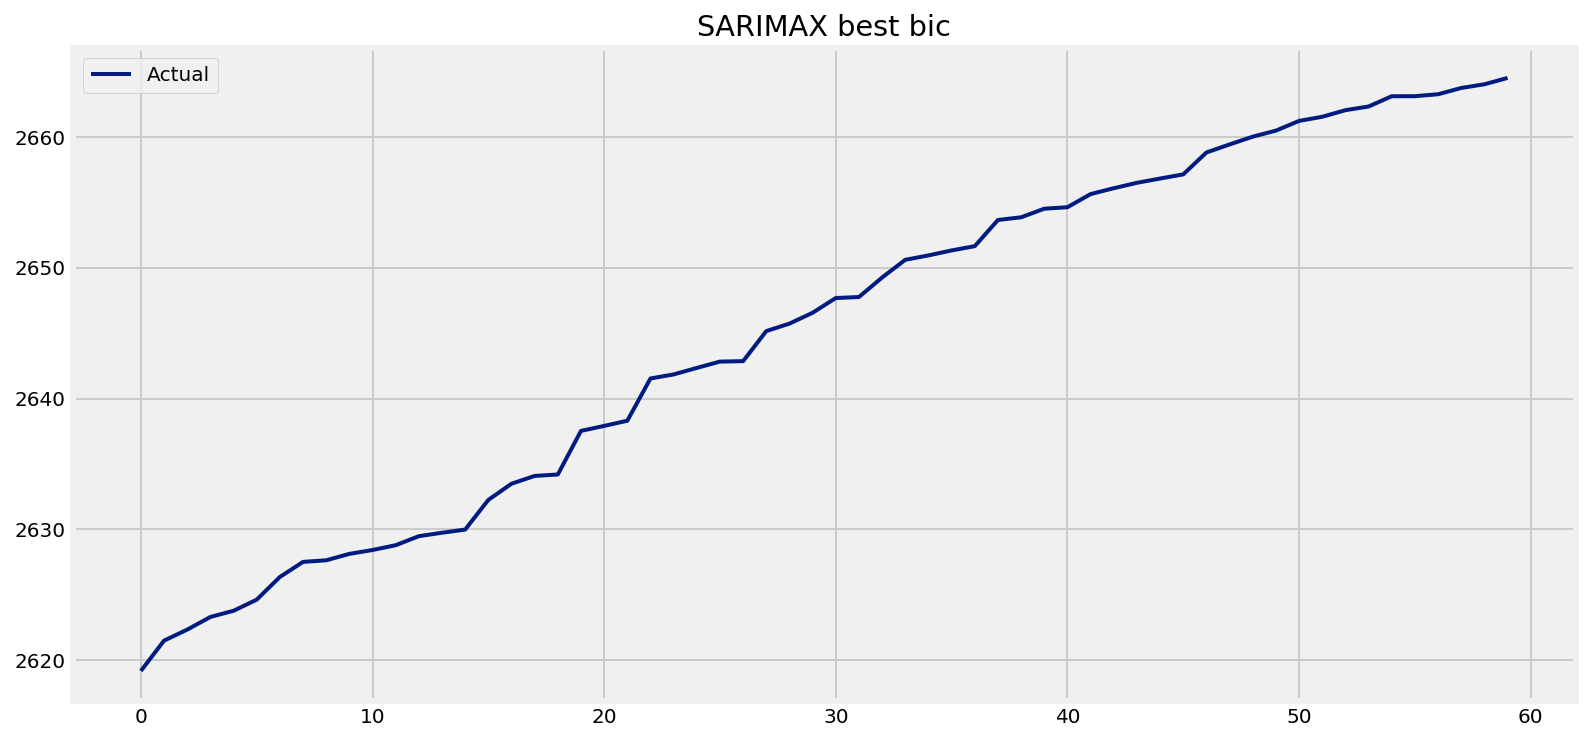

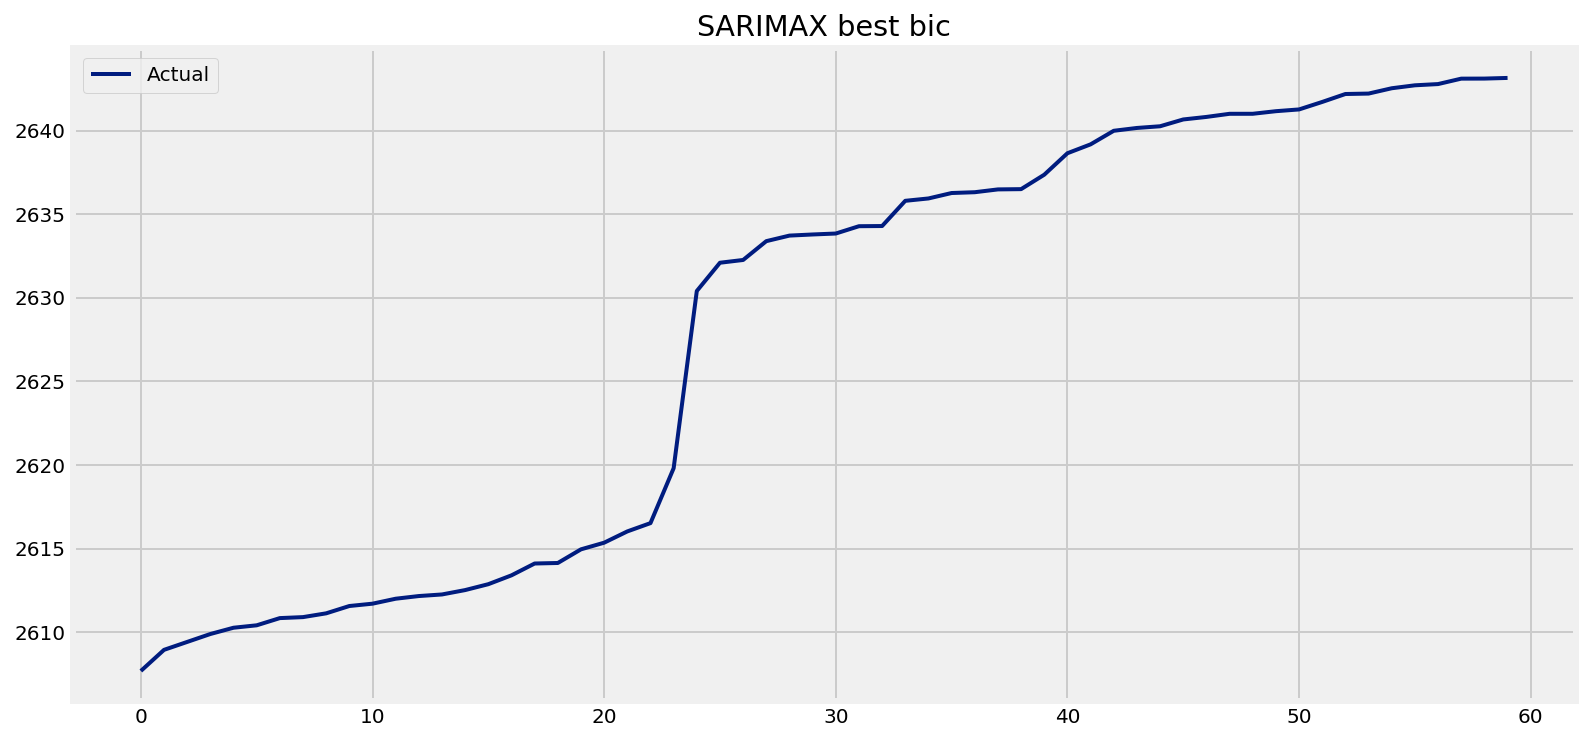

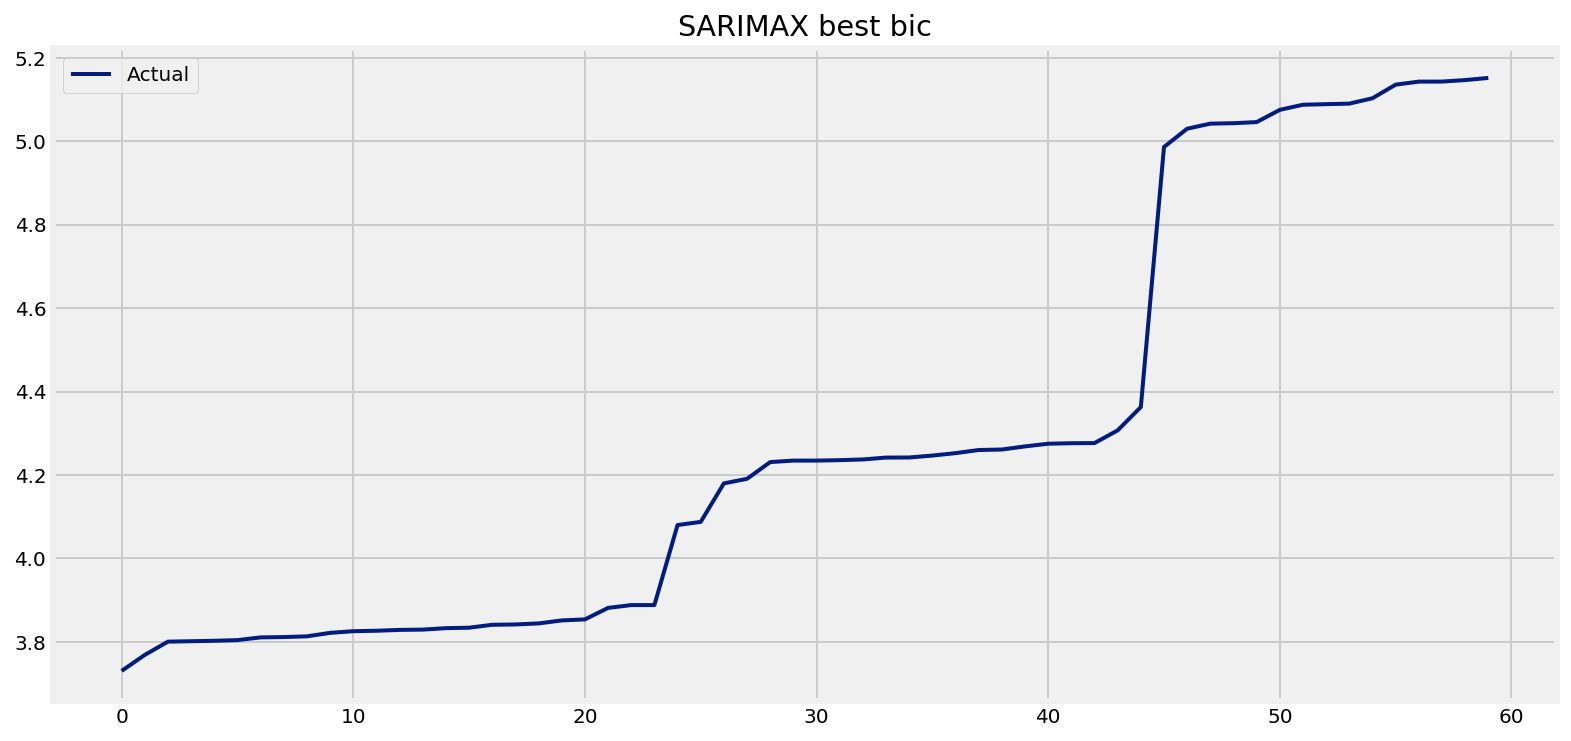

In [16]:
best_models_bic = sorted(list(results_models.items()), key=lambda x: x[1][-1])
best_models_aic = sorted(list(results_models.items()), key=lambda x: x[1][-2])
best_models_mape = sorted(list(results_models.items()), key=lambda x: x[1][-3])

print("MAPE AIC BIC:")
print("Best BIC models:")
for x in [x for x in  best_models_bic[0:10]]:
    print(x[0], x[1][1:])
print("Best AIC models:")
for x in [x for x in  best_models_aic[0:10]]:
    print(x[0], x[1][1:])
print("Best mape models:")
for x in [x for x in  best_models_mape[0:10]]:
    print(x[0], x[1][1:])
    

plt.figure(figsize=(12,6))
plt.plot([x[1][3] for x in best_models_bic[:60]])
plt.legend(['Actual','Predicted'])
plt.title("SARIMAX best bic")
plt.show()

plt.figure(figsize=(12,6))
plt.plot([x[1][2] for x in best_models_aic[:60]])
plt.legend(['Actual','Predicted'])
plt.title("SARIMAX best bic")
plt.show()

plt.figure(figsize=(12,6))
plt.plot([x[1][1] for x in best_models_mape[:60]])
plt.legend(['Actual','Predicted'])
plt.title("SARIMAX best bic")
plt.show()

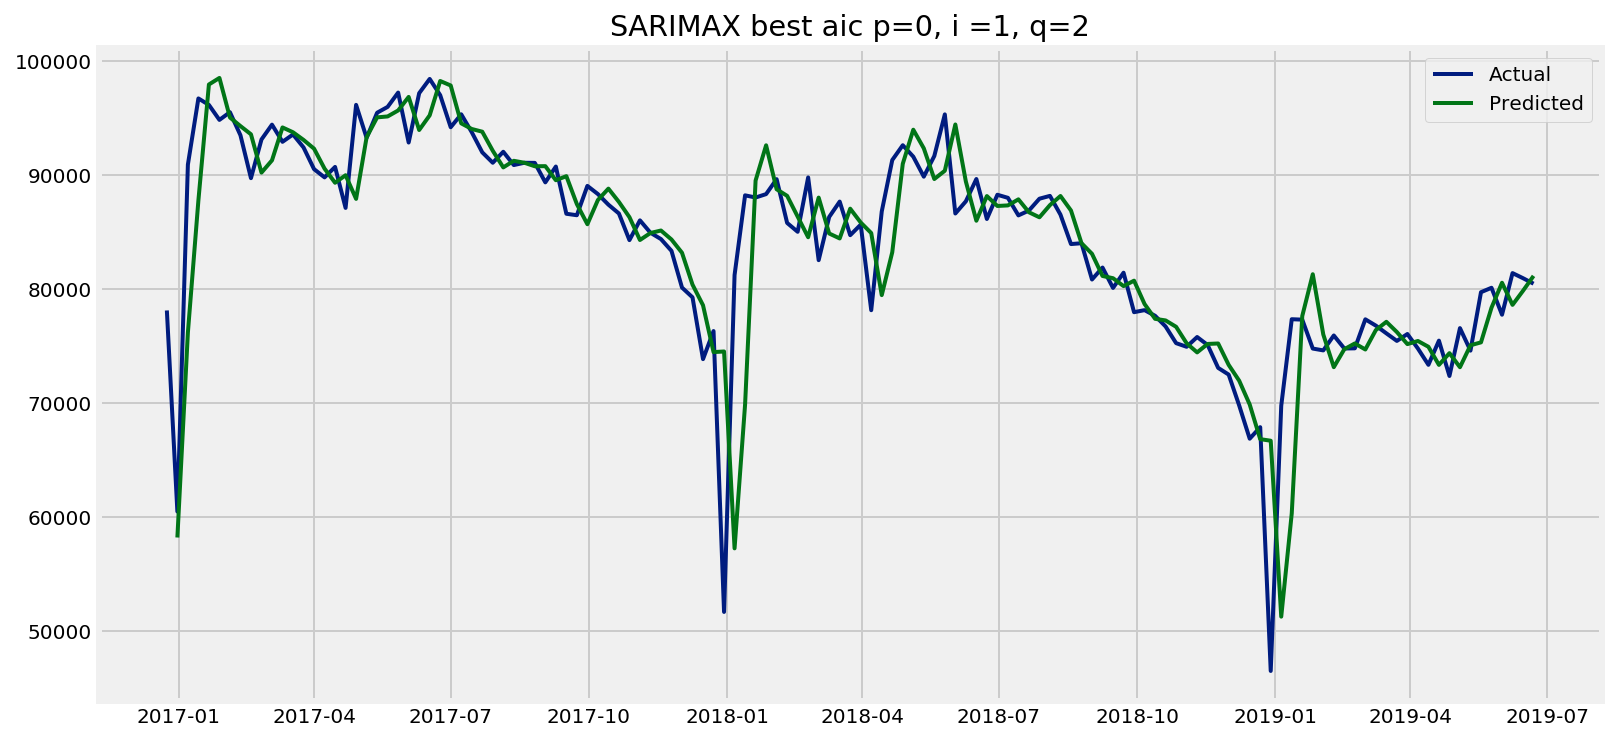

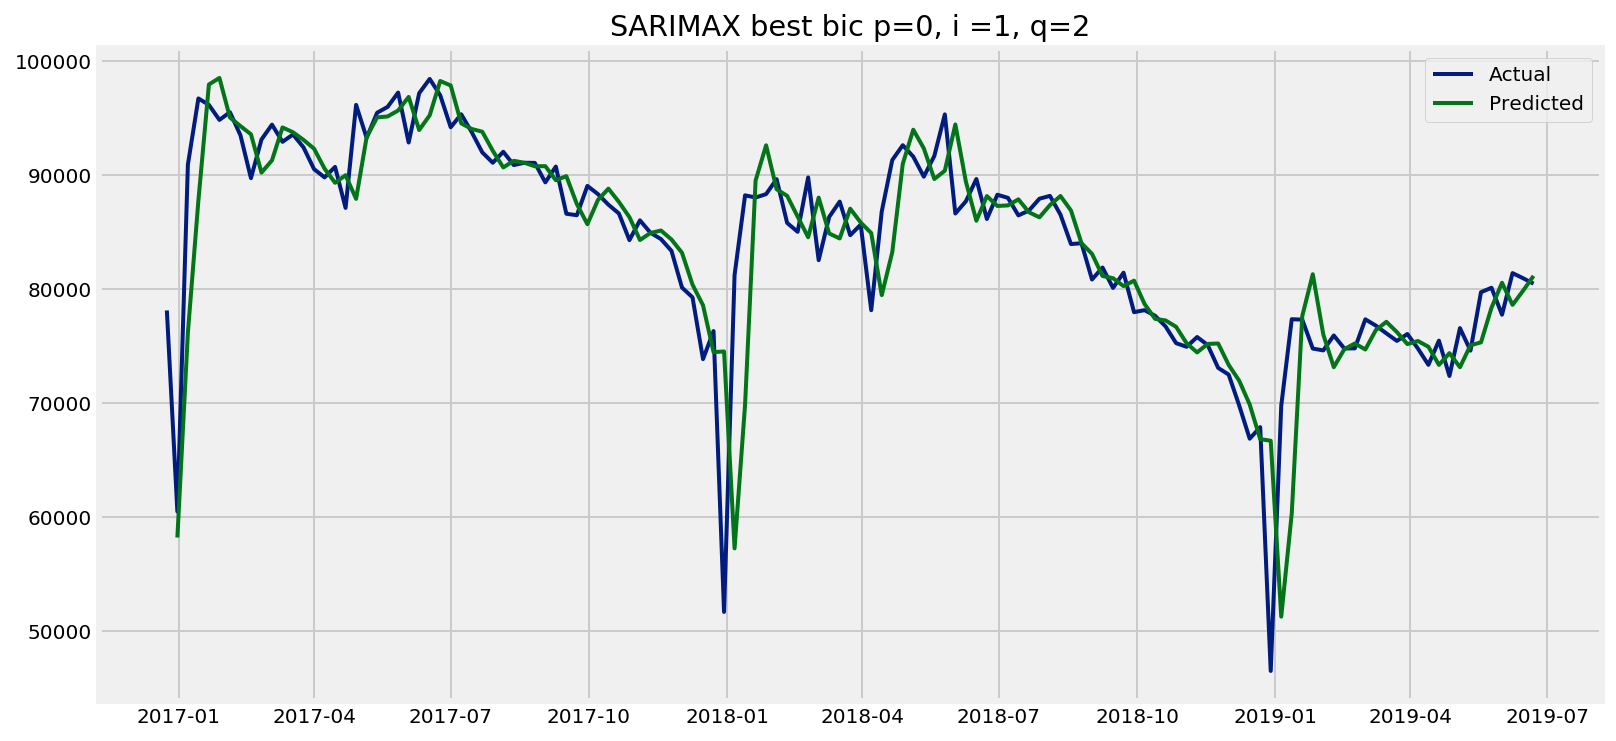

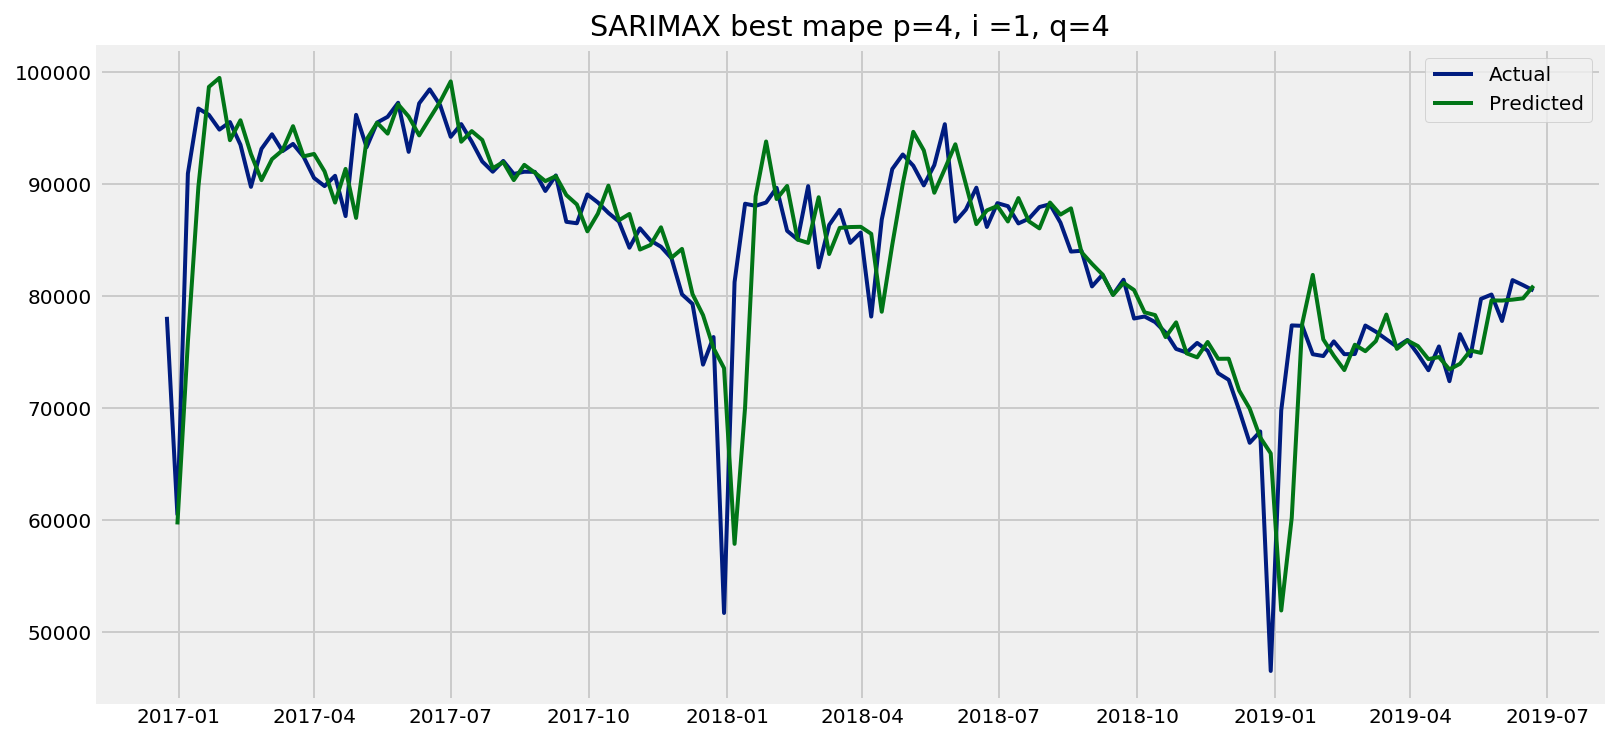

In [17]:
aic_model, bic_model, mape_model = best_models_aic[0][0], best_models_bic[0][0], best_models_mape[0][0]
aic_prediction = best_models_aic[0][1][0].predict(start=1)
bic_prediction = best_models_bic[0][1][0].predict(start=1)
mape_prediction = best_models_mape[0][1][0].predict(start=1)

plt.figure(figsize=(12,6))
# stampo l'intero train set, compresa la parte vera, poi stampo quella predetta
plt.plot(train_sample)
plt.plot(aic_prediction)
plt.legend(['Actual','Predicted'])
plt.title("SARIMAX best aic p={0}, i ={1}, q={2}".format(aic_model[0], aic_model[1], aic_model[2]))
plt.show()

plt.figure(figsize=(12,6))
# stampo l'intero train set, compresa la parte vera, poi stampo quella predetta
plt.plot(train_sample)
plt.plot(bic_prediction)
plt.legend(['Actual','Predicted'])
plt.title("SARIMAX best bic p={}, i ={}, q={}".format(bic_model[0], bic_model[1], bic_model[2]))
plt.show()

plt.figure(figsize=(12,6))
# stampo l'intero train set, compresa la parte vera, poi stampo quella predetta
plt.plot(train_sample)
plt.plot(mape_prediction)
plt.legend(['Actual','Predicted'])
plt.title("SARIMAX best mape p={}, i ={}, q={}".format(mape_model[0], mape_model[1], mape_model[2]))
plt.show()

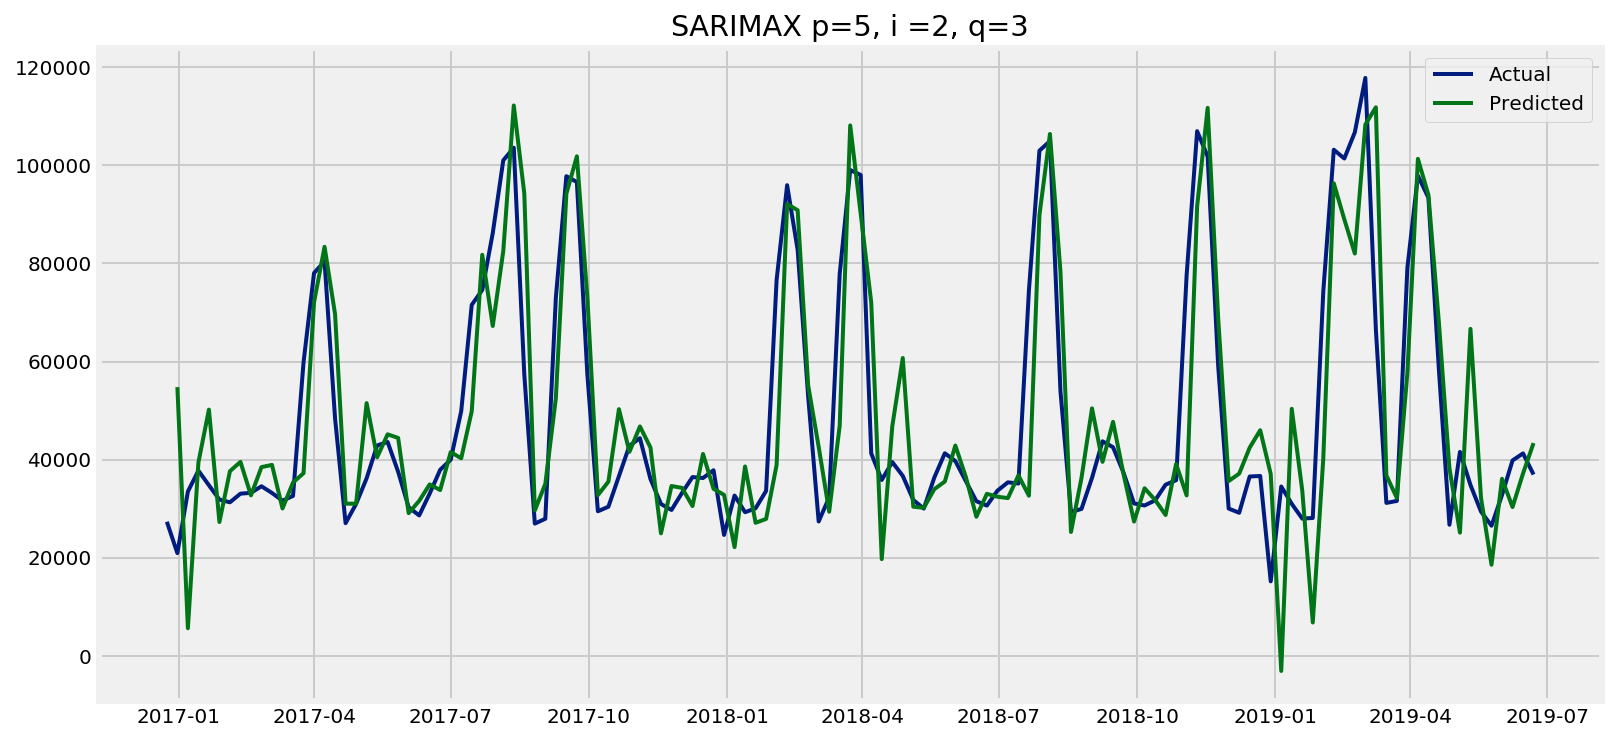

In [160]:
chosen_model = (1, 2, 3)
ar_order, i_order,ma_order = chosen_model
chosen_result = results_models[chosen_model][0]
chosen_result.summary()
prediction = chosen_result.predict(start=1)


plt.figure(figsize=(12,6))
# stampo l'intero train set, compresa la parte vera, poi stampo quella predetta
plt.plot(train_sample)
plt.plot(prediction)
plt.legend(['Actual','Predicted'])
plt.title("SARIMAX p={}, i ={}, q={}".format(ar_order, i_order,ma_order))
plt.show()